# Example of using BDE for Circadian model

In this example we build a Boolean Delay Equation of a Circadian model and show 
how it matches with experiment data.

First we need a few imports:

In [1]:
from pybde import BDESolver
from pybde import BooleanTimeSeries
from numpy import genfromtxt
import matplotlib.pyplot as plt

Now we need to obtain out experiment data

In [3]:
experiment_data = genfromtxt(
    'https://raw.githubusercontent.com/EPCCed/pybde-examples/master/neurospora_data.csv', 
    delimiter=',')

This data has expression levels of m and ft in the first two columns and time in the third column. The following shows the first three rows of data.

In [4]:
experiment_data[0:3,:]

array([[ 2.14250258, 82.10832093,  0.        ],
       [36.13871538, 36.83378   ,  2.00902432],
       [95.19299706, 56.88693908,  4.00639426]])

We can plot this data to see what it looks like

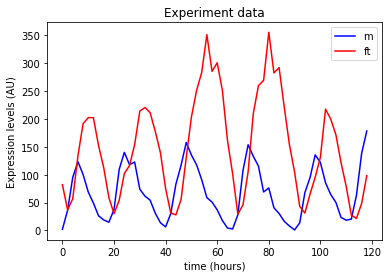

In [5]:
plt.plot(experiment_data[:,2], experiment_data[:,0], 'b-', label="m", )
plt.plot(experiment_data[:,2], experiment_data[:,1], 'r-', label="ft")
plt.legend()
plt.xlabel("time (hours)")
plt.ylabel("Expression levels (AU)")
plt.title("Experiment data")
plt.show()

To use this data in a Boolean Delay Equation we need to convert it into Boolean data.  We use the BooleanTimeSeries class to store Boolean time series data. We can create Boolean time series data from this experiment data by applying relative or absolute thresholding.

Relative thresholding thresholds the relative to the range of the values in the data.  A threshold of 0.5 will corresponding a a threshold value midway between the minimum and maximum value.

Here we choose a relative thresholdhold values of 0.3.

In [6]:
m_bts = \
    BooleanTimeSeries.relative_threshold(experiment_data[:,2], experiment_data[:,0], 0.3)
ft_bts = \
    BooleanTimeSeries.relative_threshold(experiment_data[:,2], experiment_data[:,1], 0.3)

We can now plot this Boolean data:

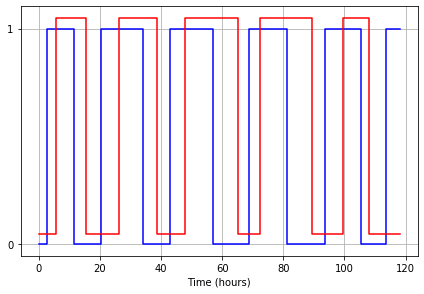

In [7]:
# Add labels and plot styles to the switch points objects
ft_bts.label = "ft"
m_bts.label = "m"
ft_bts.style = "r-"
m_bts.style = "b-"

# Plot multiple switch point lines in the same plot
BooleanTimeSeries.plot_many([m_bts, ft_bts])
plt.xlabel("Time (hours)")
plt.show()

We can plot this over the original data to easier see how it matches.  Note that we rescale the Boolean data purely for display purposes they approximately match the same scale as the experiment data. Remember that the Boolean data only has states True (1) and False (0).

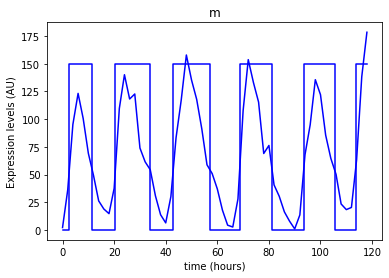

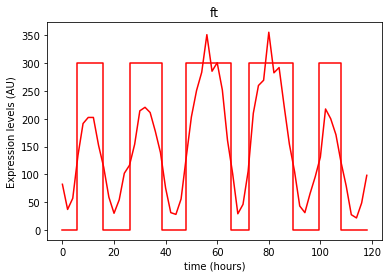

In [8]:
plt.plot(experiment_data[:,2], experiment_data[:,0], 'b-', label="m", )
m_bts.plot(scale=150)
plt.xlabel("time (hours)")
plt.ylabel("Expression levels (AU)")
plt.title("m")
plt.show()


plt.plot(experiment_data[:,2], experiment_data[:,1], 'r-', label="ft")
ft_bts.plot(scale=300)
plt.xlabel("time (hours)")
plt.ylabel("Expression levels (AU)")
plt.title("ft")
plt.show()

We wish to use the first 24 hours' worth of data as history for our simulation. So we can cut this data to extract the first 24 hours:

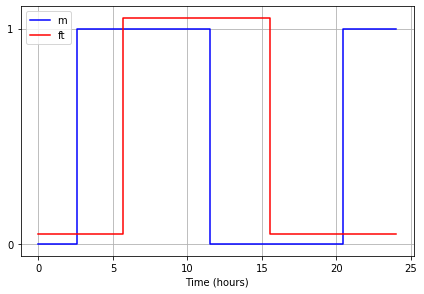

In [9]:
hist_ft = ft_bts.cut(0, 24)
hist_m = m_bts.cut(0, 24)

# Plot multiple switch point lines in the same plot
BooleanTimeSeries.plot_many([hist_m, hist_ft])
plt.xlabel("Time (hours)")
plt.legend()
plt.show()

The Circadian model uses light as an input so we need to prepare the light input:

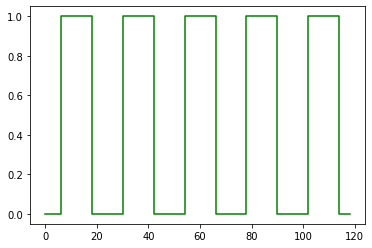

In [10]:
light_t = [0] + list(range(6,120,12))
light_y = []
for t in light_t:
    light_y.append(6 <= t % 24 < 18)
light_bts = BooleanTimeSeries(light_t, light_y, 118)
light_bts.label = "light"
light_bts.style = "-g"

light_bts.plot()
plt.show()

So the inputs to our simulation are can be plotted on one graph.

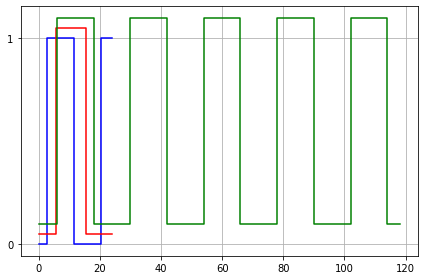

In [11]:
BooleanTimeSeries.plot_many([hist_m, hist_ft, light_bts])
plt.show()

Now we have to define our Boolean Delay Equation model.  The model has two simulated states (ft and m) and one input state (light). The model has three delays.

In [12]:
def neurospora_eqns(z, forced_inputs):
    m = 0
    ft = 1
    light = 0
    tau1 = 0
    tau2 = 1
    tau3 = 2

    return [ (not z[tau2][ft]) or forced_inputs[tau3][light], z[tau1][m] ]

For given values of the delays (determined by parameter fitting algorithms) we can run the simulation for 118 hours:

In [13]:
tau1 = 5.0752
tau2 = 6.0211
tau3 = 14.5586
delays = [tau1, tau2, tau3]

solver = BDESolver(neurospora_eqns, delays, [hist_m, hist_ft], [light_bts])
[m_output, ft_output] = solver.solve(118)

We can now plot the output of the simulation:

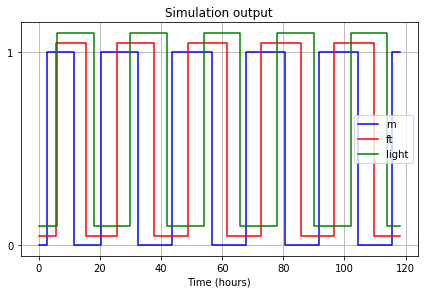

In [14]:
plt.title("Simulation output")
BooleanTimeSeries.plot_many([m_output , ft_output, light_bts])
plt.xlabel("Time (hours)")
plt.legend()
plt.show()

Plotting these outputs over the original experiment data:

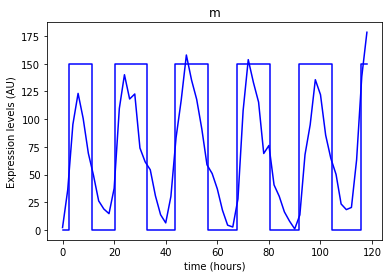

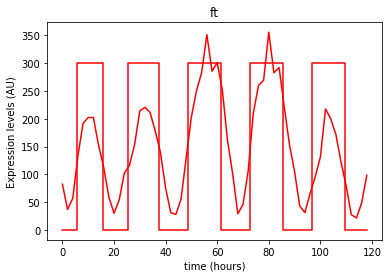

In [15]:
plt.plot(experiment_data[:,2], experiment_data[:,0], 'b-', label="m", )
m_output.plot(scale=150)
plt.xlabel("time (hours)")
plt.ylabel("Expression levels (AU)")
plt.title("m")
plt.show()


plt.plot(experiment_data[:,2], experiment_data[:,1], 'r-', label="ft")
ft_output.plot(scale=300)
plt.xlabel("time (hours)")
plt.ylabel("Expression levels (AU)")
plt.title("ft")
plt.show()

Plotting the simulated data alongside the thresholded data gives:

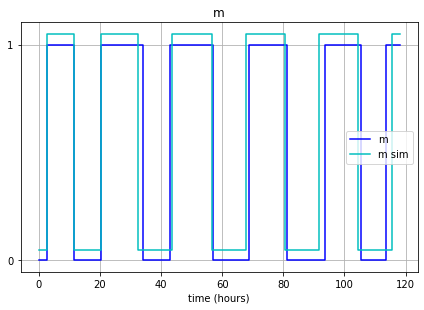

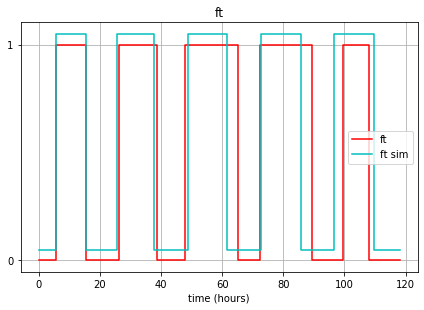

In [16]:
m_output.label = "m sim"
m_output.style = 'c-'
BooleanTimeSeries.plot_many([m_bts, m_output])
plt.xlabel("time (hours)")
plt.title("m")
plt.legend()
plt.show()

ft_output.label = "ft sim"
ft_output.style = 'c-'
BooleanTimeSeries.plot_many([ft_bts, ft_output])
plt.xlabel("time (hours)")
plt.title("ft")
plt.legend()
plt.show()

We can calculate the Hamming distance which gives a measure of what duration of time two Boolean time series have differing signals. For 96 hours of simulated time the Hamming distance measures are low:

In [17]:
print("Hamming of m : {:.4f}".format(m_bts.hamming_distance(m_output)))
print("Hamming of ft : {:.4f}".format(ft_bts.hamming_distance(ft_output)))

print("Hamming of m as %age of simulated time: {:.2f}%".format(
    m_bts.hamming_distance(m_output)/0.96))
print("Hamming of ft as %age of simulated time : {:.2f}%".format(
    ft_bts.hamming_distance(ft_output)/0.96))


Hamming of m : 9.3353
Hamming of ft : 14.7796
Hamming of m as %age of simulated time: 9.72%
Hamming of ft as %age of simulated time : 15.40%
